# Image Segmentation

This notebook is based on the code samples of Chapter 9, Section 9.2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks.



In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow import keras
keras.__version__

'2.11.0'

## The Oxford-IIIT Pets Dataset

We will use the Oxford-IIIT Pets dataset (www.robots.ox.ac.uk/~vgg/data/pets/), which contains 7,390 pictures of cats and dogs, together with foreground-background segmentation masks for each picture. The pixels of our segmentation masks can take one of three integer values:

- 1 (foreground)
- 2 (background)
- 3 (contour)

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-03-17 06:42:34--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-03-17 06:42:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-03-17 06:42:34--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

Let's now prepare the list of input file paths and their corresponding mask file paths.

In [4]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

Here is a sample image and its corresponding mask

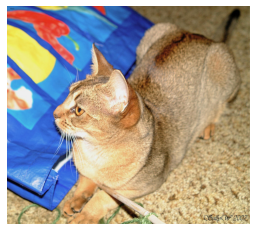

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

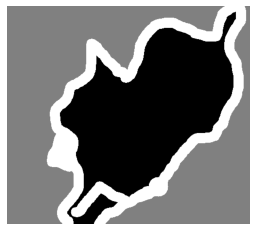

In [6]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0], cmap="gray")

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

To display the mask, note that we have subtracted 1 so that the numbers are 0, 1, 2, and multiplied by 127 so that the final numbers are 0 (black), 1 (grey), and 254 (near white). This is only so that they can be displayed clearly.

Let's now load the inputs and targets into NumPy arrays and split the data into a training and a validation set. Since the dataset is very small, we can just load everything into memory.

In [7]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

We now define the model. Note that we use first a sequence of convolutional layers that gradually reduce the image size, and then a sequence of transposed convolutions to upsample the image to the original size. This is a standard architecture for image segmentation, and for image generation in general.

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

Note how the last layer, which is used for classification, is a convolution with depth 3 and softmax activation, and the final tensor generated is of size 200 x 200 x 3. This will make it possible to generate the label probabilities for each possible label and for every pixel in the image.

We now compile and train the model. We will use a special call-back function that will save a checkpoint for the epoch that has the optimal (minimum) loss with the validation set. We will then be able to load the checkpoint and use it for the final predictions.

In [9]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/20
100/100 [==============================] - 84s 663ms/step - loss: 0.9455 - val_loss: 0.8949
Epoch 2/20
100/100 [==============================] - 60s 602ms/step - loss: 0.8870 - val_loss: 0.8977
Epoch 3/20
100/100 [==============================] - 62s 625ms/step - loss: 0.8457 - val_loss: 0.8510
Epoch 4/20
100/100 [==============================] - 63s 628ms/step - loss: 0.8101 - val_loss: 0.7597
Epoch 5/20
100/100 [==============================] - 64s 642ms/step - loss: 0.7910 - val_loss: 0.7871
Epoch 6/20
100/100 [==============================] - 63s 634ms/step - loss: 0.7631 - val_loss: 0.7390
Epoch 7/20
100/100 [==============================] - 64s 643ms/step - loss: 0.7552 - val_loss: 0.8276
Epoch 8/20
100/100 [==============================] - 63s 633ms/step - loss: 0.7382 - val_loss: 0.7138
Epoch 9/20
100/100 [==============================] - 65s 648ms/step - loss: 0.7258 - val_loss: 0.7100
Epoch 10/20
100/100 [==============================] - 63s 630ms/step - l

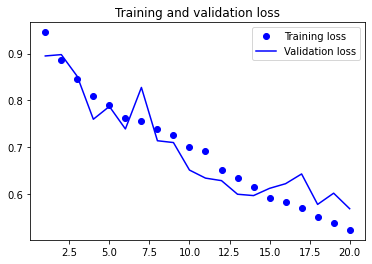

In [10]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

We finally try the saved checkpoint on an image. To load the model saved on the same directory, we can use:

`model = keras.models.load_model("oxford_segmentation.keras")`

For this notebook we will load a model that has been created in a previous run of the above training code, which has been run on a larger number of epochs, and is available on Google Drive here:
- [oxford_segmentation.keras](https://drive.google.com/file/d/1edzzqj0HajoNvZ_XCj3UEnjhK2w-ohvu/view?usp=share_link)

In [14]:
cp drive/MyDrive/Teaching/COMP3420/oxford_segmentation.keras oxford_segmentation2.keras

In [15]:
model = keras.models.load_model("oxford_segmentation2.keras")

We now use the model created from the saved checkpoint to process an image. 
Note how we use `argmax` to find the label with highest probability. This label has the value 0, 1, or 2.

1/1 [==============================] - 0s 215ms/step


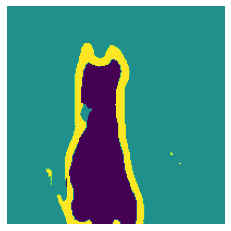

In [16]:
from tensorflow.keras.utils import array_to_img

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)